# Özel Bir Veri Seti Üzerinde Semantik Segmentasyon Modeli Fine-Tuning Etmek ve Inference API Üzerinden Kullanımı

_Yazar: [Sergio Paniego](https://github.com/sergiopaniego)_
_Çevirmen: [Onuralp Sezer](https://github.com/onuralpszr)_


Bu notebook'ta, özel veri seti üzerinde bir [semantik segmentasyon](https://huggingface.co/tasks/image-segmentation) modelinin fine tune sürecini adım adım gözden geçireceğiz. Kullanacağımız model, segmentasyon görevleri için güçlü ve esnek bir transformer mimarisi tabanlı olan ve önceden eğitilmiş [Segformer](https://huggingface.co/docs/transformers/model_doc/segformer) olacaktır.

![Segformer mimarisi](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/segformer_architecture.png)

Veri seti olarak, etiketli kaldırım görüntüleri içeren [segments/sidewalk-semantic](https://huggingface.co/datasets/segments/sidewalk-semantic) veri setini kullanacağız; bu modelimizi kentsel ortamlardaki uygulamalar için ideal hale getirecek.

Örnek kullanım durumu: Bu model, pizza siparişlerinizi kapınıza kadar teslim etmek için kaldırımda otonom olarak gezinme yeteneğine sahip bir teslimat robotunda kullanılabilir. 🍕

Modeli Fine-Tune yaptıktan sonra, onu [Serverless Inference API](https://huggingface.co/docs/api-inference/index) kullanarak nasıl kullanacağımızı göstereceğiz ve basit bir API endpoint aracılığıyla erişilebilir hale getireceğiz.

## 1. Kütüphanelerin Kurulumu

Başlamak için, semantik segmentasyon modelimizi fine-tuning yapmak için gerekli olan temel kütüphaneleri yükleyeceğiz.

In [ ]:
!pip install -q datasets transformers evaluate wandb
# datasets==3.0.0, transformers==4.44.2, evaluate==0.4.3, wandb==0.18.1 ile test edildi

## 2. Verisetinin Yüklenmesi 📁

Belçika'da 2021 yılı yazında toplanan kaldırım görüntülerinden oluşan [sidewalk-semantic](https://huggingface.co/datasets/segments/sidewalk-semantic) veri setini kullanacağız.

Veri seti şunları içermektedir:

* **1.000 görüntü ve bunlara karşılık gelen semantik segmentasyon maskeleri** 🖼
* **34 farklı kategori** 📦

Bu veri seti sınırlı erişimdedir, bu yüzden erişim sağlamak için oturum açmanız ve lisansı kabul etmeniz gerekmektedir. Ayrıca, eğitimin ardından fine-tuned modeli Hub'a yüklemek için kimlik doğrulaması gerekmektedir.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
sidewalk_dataset_identifier = "segments/sidewalk-semantic"

In [ ]:
from datasets import load_dataset

dataset = load_dataset(sidewalk_dataset_identifier)

Veri setine, yapısını inceleyerek aşina olun!

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

Veri seti sadece eğitim seti içerdiği için, bunu manuel olarak `eğitim ve test setlerine` ayıracağız. Verilerin %80'ini eğitim için ayıracak ve kalan %20'sini değerlendirme ve test için saklayacağız. ➗

In [9]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

Bir örnekte bulunan nesne türlerini inceleyelim. `pixels_values` RGB görüntüyü tutarken, `label` gerçek referans maske(ground truth mask) içeriyor. Maske, her pikselin RGB görüntüsündeki karşılık gelen pikselin kategorisini temsil ettiği tek kanallı bir görüntüdür.

In [10]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

## 3. Örneklerin Görselleştirilmesi! 👀

Veri setini yükledikten sonra, yapısını daha iyi anlamak için birkaç örneği maskeleriyle birlikte görselleştirelim.

Veri seti, her bir ID ile ilişkilendirilen kategori etiketlerini içeren bir JSON [dosyası](https://huggingface.co/datasets/segments/sidewalk-semantic/blob/main/id2label.json) içerir. Bu dosyayı açarak her `id2label` ile eşleşenleri okuyacağız.

In [11]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

Id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


Her kategoriye renkler atayalım 🎨. Bu, segmentasyon sonuçlarını daha etkili bir şekilde görselleştirmemize ve görüntülerimizdeki farklı kategorileri yorumlamamızı kolaylaştıracaktır.

In [12]:
sidewalk_palette = [
  [0, 0, 0], # unlabeled / etiketlenmemiş
  [216, 82, 24], # flat-road / düz-yol
  [255, 255, 0], # flat-sidewalk / düz-kaldırım
  [125, 46, 141], # flat-crosswalk / düz-yaya geçidi
  [118, 171, 47], # flat-cyclinglane / düz-bisiklet yolu
  [161, 19, 46], # flat-parkingdriveway / düz-park yeri/garaj yolu
  [255, 0, 0], # flat-railtrack / düz-ray hattı
  [0, 128, 128], # flat-curb / düz-kaldırım kenarı
  [190, 190, 0], # human-person / insan-kişi
  [0, 255, 0], # human-rider / insan-sürücü
  [0, 0, 255], # vehicle-car / araç-araba
  [170, 0, 255], # vehicle-truck / araç-kamyon
  [84, 84, 0], # vehicle-bus / araç-otobüs
  [84, 170, 0], # vehicle-tramtrain / araç-tramvay/tren
  [84, 255, 0], # vehicle-motorcycle / araç-motosiklet
  [170, 84, 0], # vehicle-bicycle / araç-bisiklet
  [170, 170, 0], # vehicle-caravan / araç-karavan
  [170, 255, 0], # vehicle-cartrailer / araç-römork
  [255, 84, 0], # construction-building / inşaat-bina
  [255, 170, 0], # construction-door / inşaat-kapı
  [255, 255, 0], # construction-wall / inşaat-duvar
  [33, 138, 200], # construction-fenceguardrail / inşaat-çit/korkuluk
  [0, 170, 127], # construction-bridge / inşaat-köprü
  [0, 255, 127], # construction-tunnel / inşaat-tünel
  [84, 0, 127], # construction-stairs / inşaat-merdiven
  [84, 84, 127], # object-pole / nesne-direk
  [84, 170, 127], # object-trafficsign / nesne-trafik levhası
  [84, 255, 127], # object-trafficlight / nesne-trafik ışığı
  [170, 0, 127], # nature-vegetation / doğa-bitki örtüsü
  [170, 84, 127], # nature-terrain / doğa-arazi
  [170, 170, 127], # sky / gökyüzü
  [170, 255, 127], # void-ground / boşluk-zemin
  [255, 0, 127], # void-dynamic / boşluk-dinamik
  [255, 84, 127], # void-static / boşluk-statik
  [255, 170, 127], # void-unclear / boşluk-belirsiz
]


Veri setinden bazı örnekleri görselleştirebiliriz; bunlar RGB görüntü ve ona karşılık gelen maske ve maskenin görüntü üzerine bindirilmiş hali bulunur. Bu, veri setini ve maskelerin görüntülerle nasıl eşleştiğini daha iyi anlamamıza yardımcı olacaktır. 📸

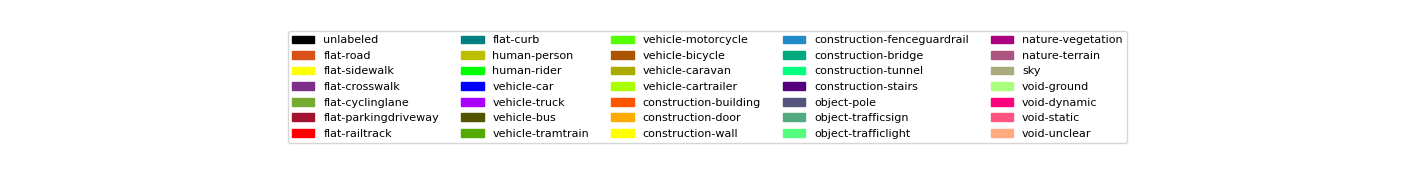

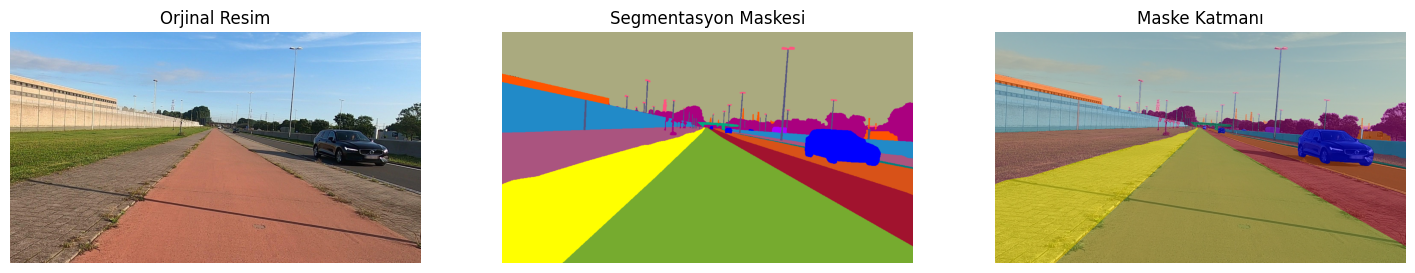

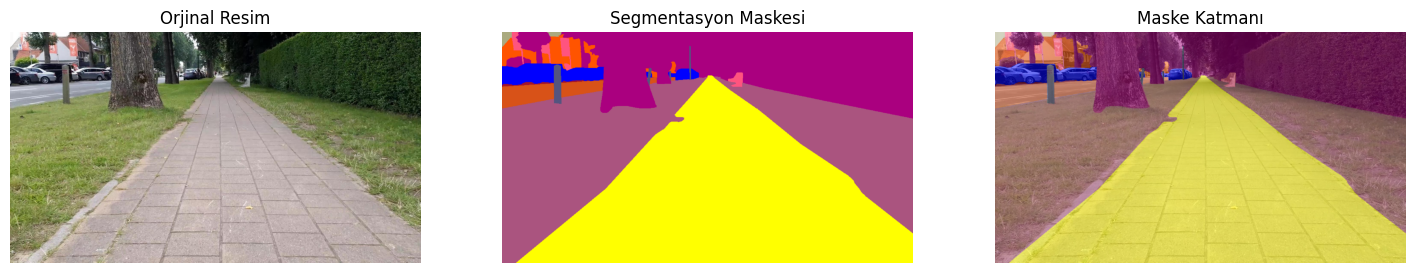

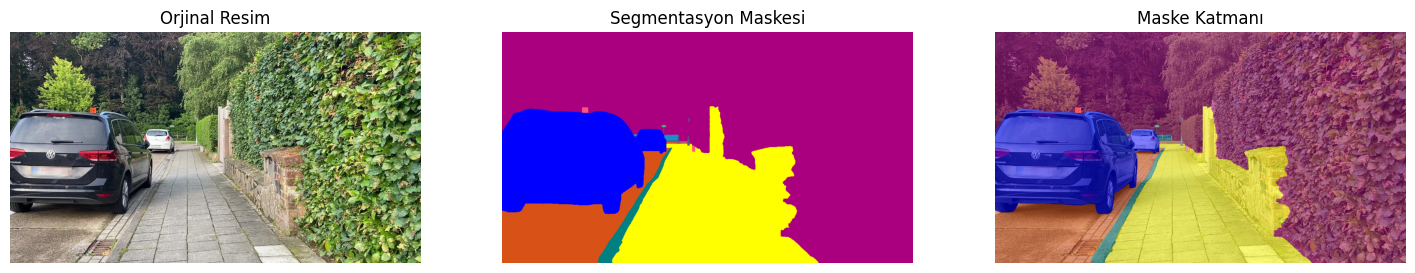

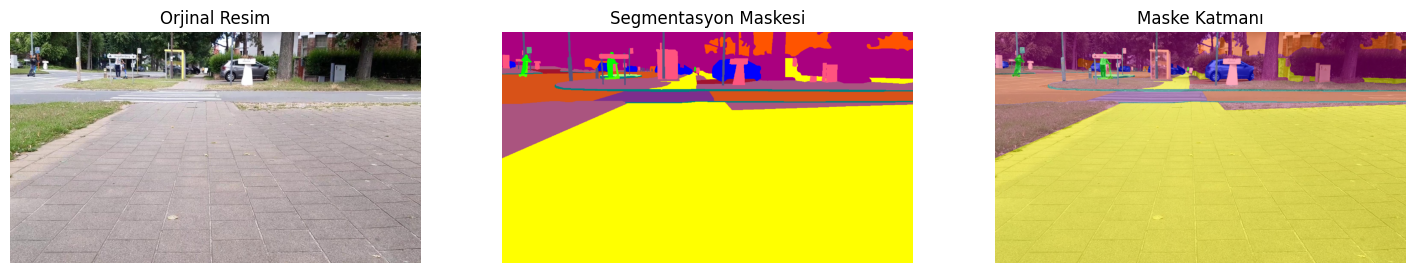

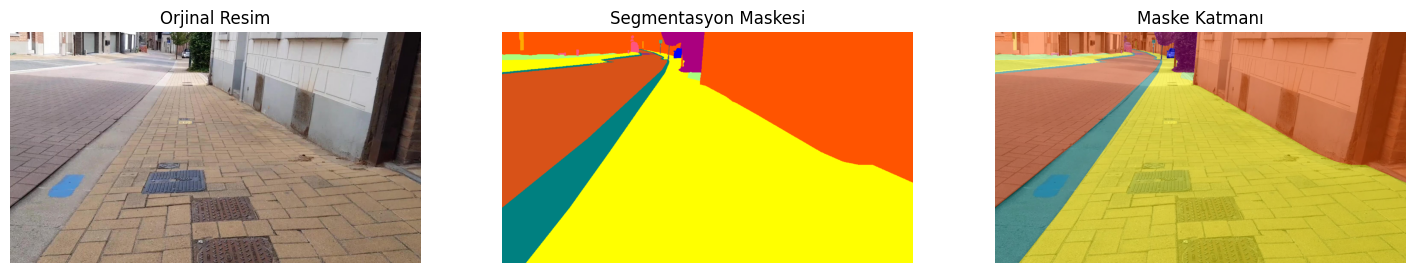

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Legend'i(Açıklama/lejant) ayrı olarak oluştrup ve gösterelim
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [patches.Patch(color=np.array(color)/255, label=label) for label, color in zip(id2label.values(), sidewalk_palette)]

ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis('off')

plt.show()

for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Orjinal resmi göster
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Orjinal Resim')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Boş bir RGB resim oluştur
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Her etikete denk gelen maske için bir renk atayalım
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Segmentasyon maskesini göster
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentasyon Maskesi')
    ax[1].axis('off')

    # Şeffaflığı desteklemek için orijinal görüntüyü RGBA formatına dönüştürün
    image_rgba = image['pixel_values'].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Maskenin şeffaflığını ayarlayın
    alpha = 128  # Şeffaflık seviyesi (0 tamamen şeffaf, 255 tamamen opak)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Maske Katmanı')
    ax[2].axis('off')

    plt.show()

## 4. Sınıf Görünümlerini Görselleştirme 📊

Veri seti hakkında daha derinlemesine bilgiler edinmek için, her bir sınıfın görünüm sayılarını grafiğe dökelim. Bu, sınıfların dağılımını anlamamıza ve veri setindeki olası önyargıları veya dengesizlikleri belirlememize yardımcı olacaktır.


In [14]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example['label'])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

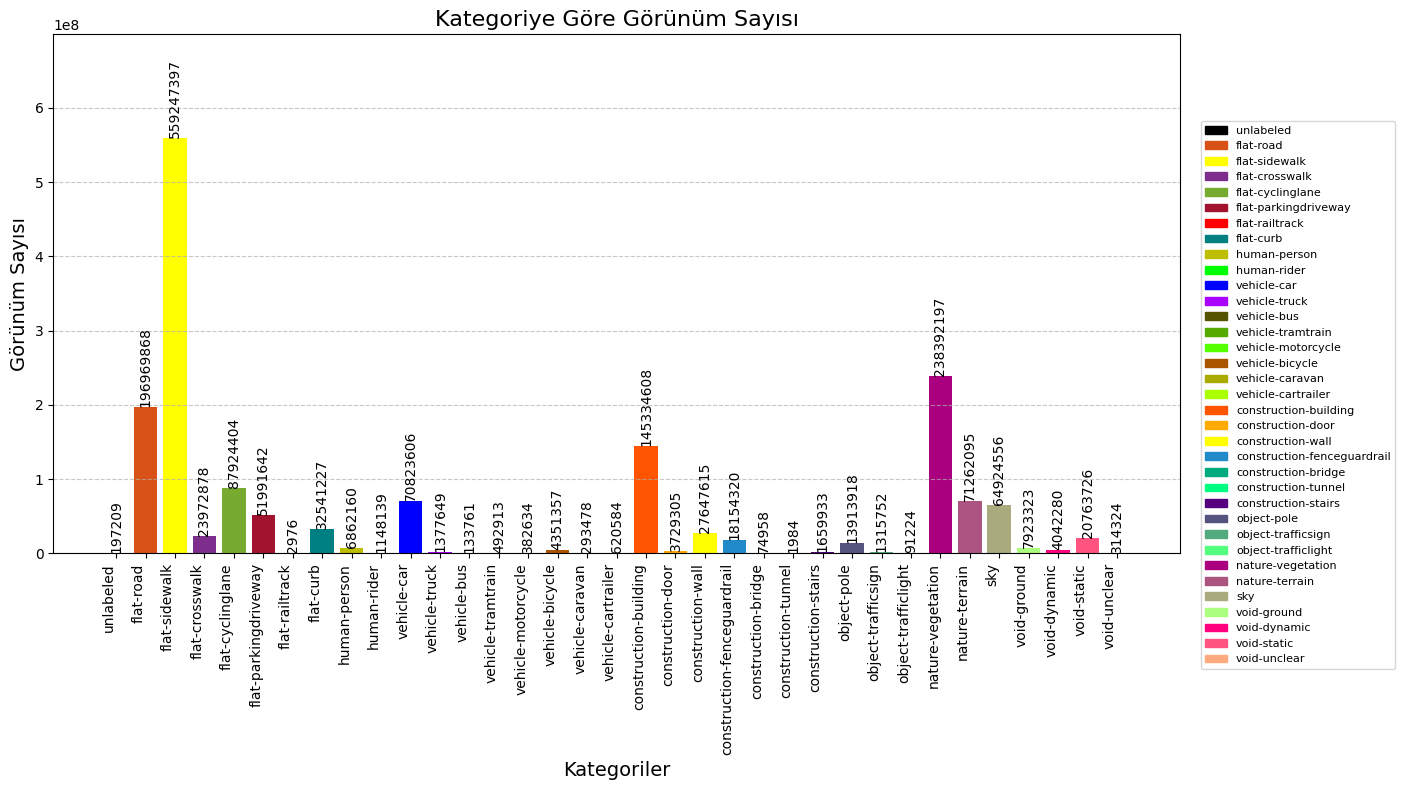

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# Renkleri [0, 1] aralığına normalleştir
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

# Görselleştirme
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Kategoriler", fontsize=14)
ax.set_ylabel("Görünüm Sayısı", fontsize=14)
ax.set_title("Kategoriye Göre Görünüm Sayısı", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Y ekseni limitini ayarlayın
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Metin konumunu ayarlayın
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f"{height}",
            ha="center", va="bottom", rotation=90, fontsize=10, color='black')

fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8)  # ncol'u gereken durumlarda ayarlayın

plt.tight_layout()
plt.show()

## 5. Image Processor'un Oluşturulması ve Albumentations ile Veri Artırımı Yapımı (Data Augmentation) 📸

Image Processor'u oluşturduktan sonra [Albumentations](https://albumentations.ai/) kullanarak veri artırımı 🪄 uygulayacağız. Bu, veri setimizi zenginleştirmeye ve semantik segmentasyon modelimizin performansının artmasına yardımcı olacaktır.


In [ ]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
    A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.4),
])

def train_transforms(example_batch):
    augmented_images = [albumentations_transform(image=np.array(x))['image'] for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(augmented_images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs


# Transformları ayarlayın
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## 6. Modeli Checkpoint'ten Başlatın

[nvidia/mit-b0](https://huggingface.co/nvidia/mit-b0) checkpoint'inden önceden eğitilmiş bir Segformer modelini kullanacağız. Bu mimari, [SegFormer: Transformers ile Semantik Segmentasyon için Basit ve Verimli Tasarım - (SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers)](https://arxiv.org/abs/2105.15203) başlıklı çalışmada detaylandırılmıştır ve ImageNet-1k üzerinde önceden eğitilmiştir.

In [ ]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

## 7. Eğitim Argümanlarını Ayarlayın ve Weights & Biases ile Bağlantı Kurulumu 📉

Sonraki adımda, eğitim argümanlarını yapılandırılması ve [Weights & Biases (W&B)](https://wandb.ai/) ile bağlantı kuracağız. W&B, deneyleri takip etmemize, metrikleri görselleştirmemize ve model eğitim iş akışını yönetmemize yardımcı olacak, süreç boyunca değerli bilgiler sağlayacaktır.


In [ ]:
from transformers import TrainingArguments

output_dir = "segformer-b0-segments-sidewalk-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="wandb"
)

In [ ]:
import wandb

wandb.init(
    project="segformer-b0-segments-sidewalk-finetuned",  # bunu değiştirin
    name="segformer-b0-segments-sidewalk-finetuned",  # bunu değiştirin
    config=training_args,
)

## 8. `evaluate` ile Geliştirilmiş Loglama için Özel `compute_metrics` Methodunu Ayarlanamsı

Modelin performansını değerlendirmek için birincil metrik olarak [ortalama kesiştirilmiş Bölgeler  -  mean Intersection over Union (ortalama IoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou) kullanacağız. Bu, her kategorideki performansı detaylı bir şekilde takip etmemizi sağlayacaktır.

Ayrıca, çıktıdaki uyarıları en aza indirmek için değerlendirme modülünün loglama seviyesini ayarlayacağız. Bir kategori bir görüntüde tespit edilmezse, aşağıdaki gibi uyarılar görebilirsiniz:

```
RuntimeWarning: invalid value encountered in divide iou = total_area_intersect / total_area_union
```

Bu hücreyi atlayabilirsiniz eğer bu uyarıları görmek isterseniz ve bir sonraki adıma geçebilirsiniz.

In [ ]:
import evaluate
evaluate.logging.set_verbosity_error()

In [ ]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # Etiket boyutuna göre logitleri ölçeklendirin
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    # şimdilik compute yerine _compute kullanılıyor: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    pred_labels = logits_tensor.detach().cpu().numpy()
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

    # kategorilere özel metrikleri ayrı key-value çiftleri olarak ekleyin
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

## 9. Modeli Özel Veri Setimiz Üzerinde Eğitimi 🏋

Artık modeli özel veri setimiz üzerinde eğitme zamanı geldi. Eğitim sürecini izlemek ve gerekirse ayarlamalar yapmak için hazırlanan eğitim argümanlarını ve bağlı Weights & Biases entegrasyonunu kullanacağız. Eğitime başlayalım ve modelin performansını geliştirmesini izleyelim!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

## 10. Yeni Görüntüler Üzerinde Model Performansını Değerlendirelim 📸

Eğitimden sonra, modelin yeni görüntüler üzerindeki performansını değerlendireceğiz. Bir test görüntüsü kullanacak ve modelin görünmeyen veriler üzerindeki performansını değerlendirmek için bir [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) kullanacağız.


In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

image = Image.open(requests.get(url, stream=True).raw)

image_segmentator = pipeline(
    "image-segmentation", model="sergiopaniego/segformer-b0-segments-sidewalk-finetuned" # Bu model adını kendi eğittiniz model ile değiştirin
)

results = image_segmentator(image)

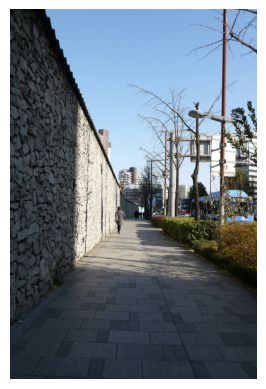

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

Model bazı maskeler oluşturdu, bunları görselleştirerek performansını değerlendirebilir ve anlayabiliriz. Bu, modelin görüntülerinin ne kadar iyi segmente edildiğini görmemize ve iyileştirmemiz gerektiren alanları belirlememize yardımcı olacaktır.

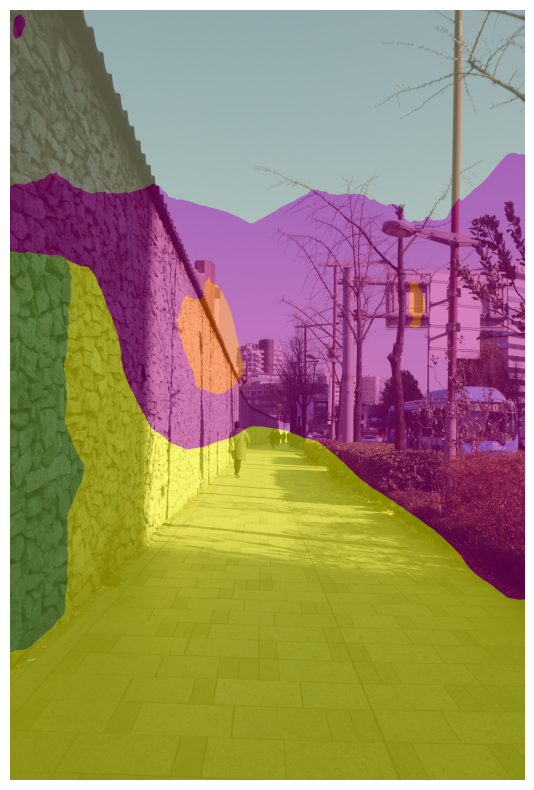

In [ ]:
image_array = np.array(image)

segmentation_map = np.zeros_like(image_array)

for result in results:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

## 11. Test Set Üzerinde Performansı Değerlendirin 📊

In [ ]:
metrics = trainer.evaluate(test_ds)
print(metrics)

## 12. Modeli Inference API'si ile Erişip ve Sonuçları Görselleştirelim 🔌

Hugging Face 🤗, "API endpoint" aracılığıyla modelleri doğrudan test etmenizi sağlayan [Serverless Inference API](https://huggingface.co/docs/api-inference/index) sunmaktadır. Bu API'yi kullanma konusunda ayrıntılı bilgi için bu [cookbook](https://huggingface.co/learn/cookbook/enterprise_hub_serverless_inference_api) sayfasına göz atın.

Bu API'yi modelimizi test etmek ve API işlevselliğini öğrenmek amacıyla kullanacağız.

**ÖNEMLİ**

Serverless Inference API'sini kullanmadan önce, bir model kartı oluşturarak model görevini ayarlamanız gerekir. Fine-Tune yapılmış modeliniz için model kartını oluştururken, görevi uygun bir şekilde belirttiğinizden emin olun.


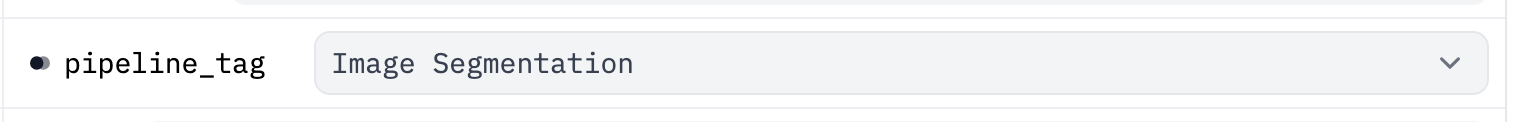


Model görevini ayarlandıktan sonra, bir görüntü indirebilir ve modeli test etmek için [InferenceClient](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client) kullanabiliriz. Bu istemci, görüntüyü API aracılığıyla modele göndermemizi ve değerlendirme için sonuçları almamızı sağlayacaktır.

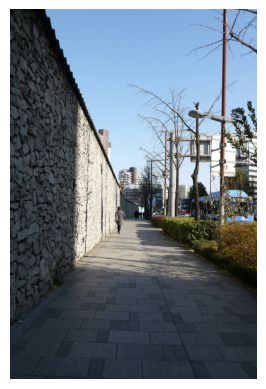

In [ ]:
url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)
plt.axis('off')
plt.show()

InferenceClient'tan [image_segmentation](https://huggingface.co/docs/huggingface_hub/v0.25.0/en/package_reference/inference_client#huggingface_hub.InferenceClient.image_segmentation) metodunu kullanacağız. Bu metod, model ve bir görüntü girişi alır ve tahmin edilen maskeleri döndürür. Bu, modelin yeni görüntüler üzerindeki performansını test etmemizi sağlayacaktır.

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient()

response = client.image_segmentation(
    model="sergiopaniego/segformer-b0-segments-sidewalk-finetuned", # Kendi modeliniz ile değiştirin
    image='https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
)

print(response)

Tahmin edilen maskelerle sonuçları görüntüleyebiliriz.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ImageSegmentationOutputElement' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(


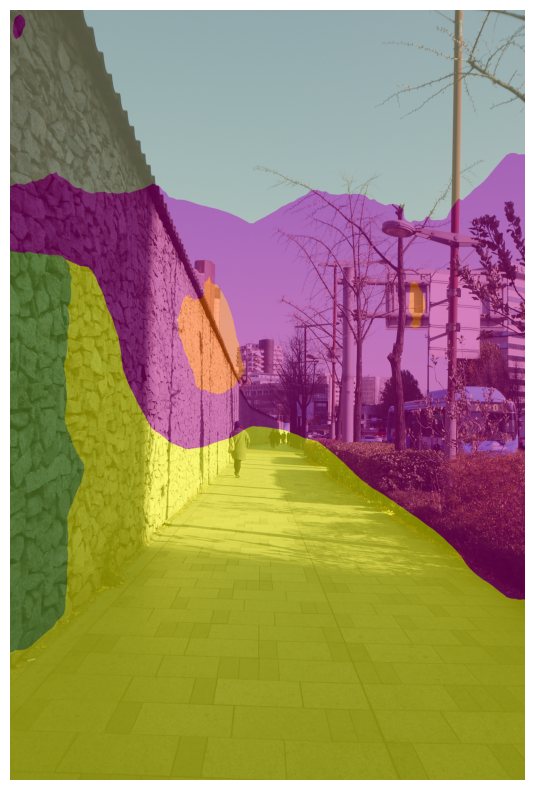

In [ ]:
image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in response:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis('off')
plt.show()

[Inferenece API'ı Javascript](https://huggingface.co/tasks/image-segmentation) ile kullanmak da mümkündür. JavaScript kullanarak API'yi kullanacağımıza dair bir örnek:

```
import { HfInference } from "@huggingface/inference";

const inference = new HfInference(HF_TOKEN);
await inference.imageSegmentation({
    data: await (await fetch("https://picsum.photos/300/300")).blob(),
    model: "sergiopaniego/segformer-b0-segments-sidewalk-finetuned",
});

```



**Ekstra Puan**

Ayrıca, Fine-Tune yapılmış modeli bir Hugging Face Space kullanarak gösterebilirsiniz. Örneğin, bunu sergilemek için özel bir Space oluşturdum: [Segformer ile Segmentler/Yaya Yolu Üzerinde Fine Tune edilmiş Semantik Segmentasyon](https://huggingface.co/spaces/sergiopaniego/segformer-b0-segments-sidewalk-finetuned).

<img src="https://huggingface.co/front/thumbnails/spaces.png" alt="HF Spaces logo" width="20%">

In [ ]:
from IPython.display import IFrame
IFrame(src='https://sergiopaniego-segformer-b0-segments-sidewalk-finetuned.hf.space', width=1000, height=800)

## Sonuç

Bu kılavuzda, özel bir veri seti üzerinde bir semantik segmentasyon modelini başarıyla fine tune yaptık ve Serverless Inference API'yi kullanarak test ettik. Bu, modeli çeşitli uygulamalara nasıl kolayca entegre edebileceğinizi ve dağıtım için Hugging Face araçlarını nasıl kullanabileceğinizi göstermektedir.

Umarım bu kılavuz, kendi modellerinizi güvenle fine tune yapma ve dağıtma konusunda size gerekli araçları ve bilgileri sağlar! 🚀